In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, accuracy_score
import seaborn as sns
import random
import torchvision
import zipfile
from tqdm import tqdm

In [3]:
n_epochs = 3
batch_size_train = 64
batch_size_test = 1000
learning_rate = 0.01
momentum = 0.5
log_interval = 10
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [ ]:
train_loader1 =   torchvision.datasets.FashionMNIST(root="./data/", train=True, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ]))
test_loader1 =   torchvision.datasets.FashionMNIST(root="./data/", train=False, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ]))

100%|██████████| 26421880/26421880 [00:02<00:00, 12794001.39it/s]


Extracting ./data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 201742.23it/s]


Extracting ./data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:01<00:00, 3693210.68it/s]


Extracting ./data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 4518157.98it/s]

Extracting ./data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



In [ ]:
def train(model, optimizer, train_loader, device, criterion, n_epochs):
    # Переводим модель в режим обучения
    model.train()
    model.to(device)
    # Список для хранения значений функции потерь
    losses_per_epoch = []

    for epoch in range(1, n_epochs + 1):
        list_process = []  # Очищаем список для каждой эпохи

        for batch_idx, (data, target) in enumerate(train_loader):
            # Переносим данные и цели на указанное устройство (например, GPU)
            data, target = data.to(device), target.to(device)

            # Обнуляем градиенты оптимизатора
            optimizer.zero_grad()

            # Подсчет прогнозов модели
            output = model(data)

            # Вычисление функции потерь (лосса) между прогнозами и истинными значениями
            loss = criterion(output, target)

            # Расчет градиентов и выполнение одного шага оптимизатора
            loss.backward()
            optimizer.step()

            # Добавляем значение лосса в список процесса обучения
            list_process.append(loss.item())

            if batch_idx % 100 == 0:
                # Выводим информацию о процессе обучения каждые 100 батчей
                print(f'Train Epoch: {epoch} [{batch_idx * len(data)}/{len(train_loader.dataset)} '
                      f'({100. * batch_idx / len(train_loader):.2f}%)]\tLoss: {loss.item():.6f}')

        # Выводим общую информацию о лоссе на данной эпохе
        epoch_loss = sum(list_process) / len(list_process)
        print(f'Train Epoch: {epoch}\tAverage Loss: {epoch_loss:.6f}')
        losses_per_epoch.append(epoch_loss)

    return losses_per_epoch

def display_images_with_predictions(model, test_loader, device):
    num_images_to_show = 5
    fig, axes = plt.subplots(1, num_images_to_show, figsize=(12, 3))

    model.eval()
    with torch.no_grad():
        for i in range(num_images_to_show):
            index = random.randint(0, len(test_loader.dataset) - 1)
            image, label = test_loader.dataset[index]
            image = image.to(device)
            output = model(image)
            _, predicted = torch.max(output, 1)
            image = image.permute(1, 2, 0).cpu().numpy()

            axes[i].imshow(image)
            axes[i].set_title(f"True: {label}, Predicted: {predicted.item()}")
            axes[i].axis('off')

    plt.show()


def train_and_evaluate_model(model, optimizer, train_loader, test_loader, device, criterion, n_epochs):
    # Обучение модели
    losses_per_epoch = train(model, optimizer, train_loader, device, criterion, n_epochs)

    # Вывод графика функции потерь по эпохам
    plt.figure(figsize=(10, 5))
    plt.plot(range(1, n_epochs + 1), losses_per_epoch)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training Loss')
    plt.show()

    # Оценка модели на тестовом наборе
    model.eval()
    correct = 0
    total = 0
    predicted_labels = []
    true_labels = []

    with torch.no_grad():
        for data in test_loader:
            images, labels = data
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            predicted_labels.extend(predicted.cpu().numpy())
            true_labels.extend(labels.cpu().numpy())

    # Вывод матрицы ошибок
    cm = confusion_matrix(true_labels, predicted_labels)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=range(10), yticklabels=range(10))
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

    # Вывод точности на тестовом наборе
    accuracy = accuracy_score(true_labels, predicted_labels)
    print(f'Accuracy on the test set: {accuracy * 100:.2f}%')

    # Демонстрация работы модели
    display_images_with_predictions(model, test_loader, device)


## 1. Классификация предметов одежды (датасет Fashion MNIST)



### 1.1 Решить задачу классификации, не используя сверточные слои.
* Предложить архитектуру модели для решения задачи
* Посчитать количество параметров модели.
* Обучить модель
* Вывести график функции потерь по эпохам.
* Используя тестовое множество

  * Продемонстрировать работу модели: вывести несколько изображений, указать над ними правильный класс и класс, предсказанный моделью.

  * Вывести матрицу ошибок.

  * Вывести значение accuracy на тестовом множестве.
* Сохранить модель

Train Epoch: 1 [0/60000 (0.00%)]	Loss: 2.335575
Train Epoch: 1 [6400/60000 (10.66%)]	Loss: 1.105049
Train Epoch: 1 [12800/60000 (21.32%)]	Loss: 0.872852
Train Epoch: 1 [19200/60000 (31.98%)]	Loss: 0.639287
Train Epoch: 1 [25600/60000 (42.64%)]	Loss: 0.525564
Train Epoch: 1 [32000/60000 (53.30%)]	Loss: 0.680458
Train Epoch: 1 [38400/60000 (63.97%)]	Loss: 0.493887
Train Epoch: 1 [44800/60000 (74.63%)]	Loss: 0.626011
Train Epoch: 1 [51200/60000 (85.29%)]	Loss: 0.573887
Train Epoch: 1 [57600/60000 (95.95%)]	Loss: 0.542146
Train Epoch: 1	Average Loss: 0.724049
Train Epoch: 2 [0/60000 (0.00%)]	Loss: 0.488627
Train Epoch: 2 [6400/60000 (10.66%)]	Loss: 0.508035
Train Epoch: 2 [12800/60000 (21.32%)]	Loss: 0.409039
Train Epoch: 2 [19200/60000 (31.98%)]	Loss: 0.661518
Train Epoch: 2 [25600/60000 (42.64%)]	Loss: 0.358342
Train Epoch: 2 [32000/60000 (53.30%)]	Loss: 0.395340
Train Epoch: 2 [38400/60000 (63.97%)]	Loss: 0.486738
Train Epoch: 2 [44800/60000 (74.63%)]	Loss: 0.267079
Train Epoch: 2 [5120

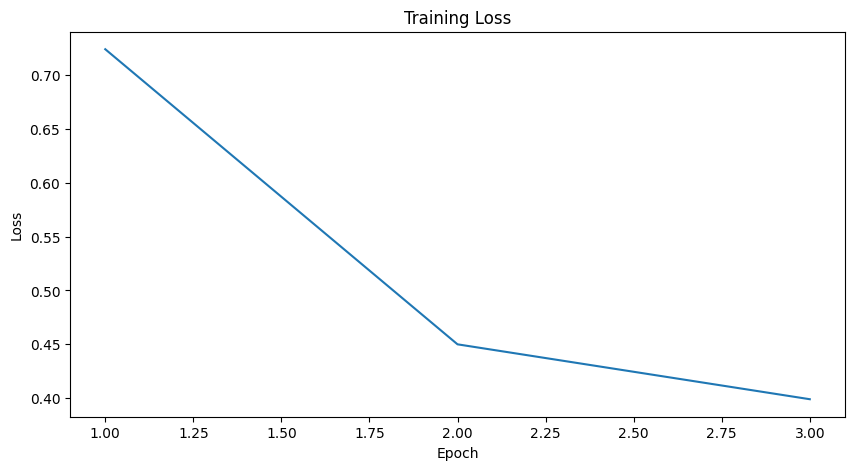

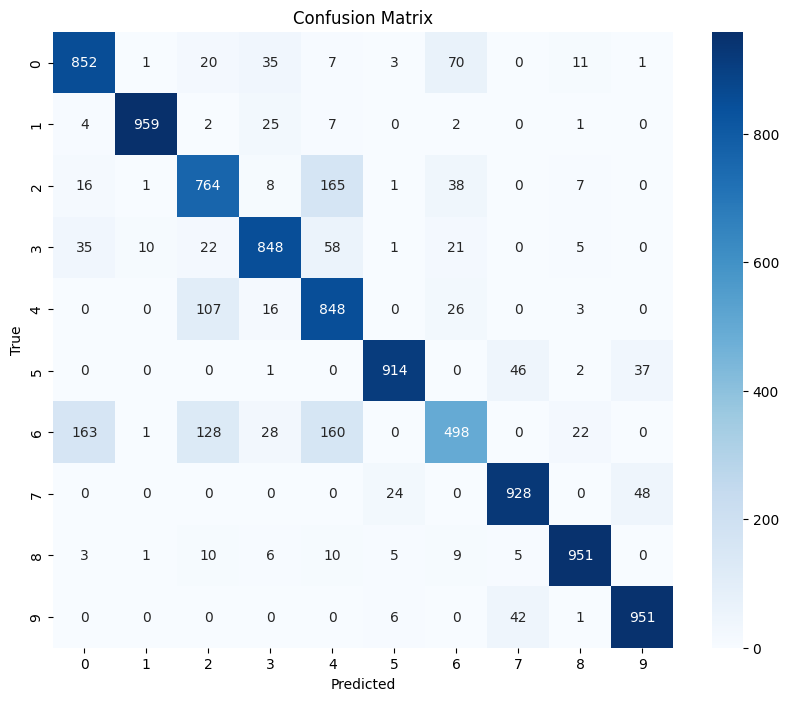

Accuracy on the test set: 85.13%


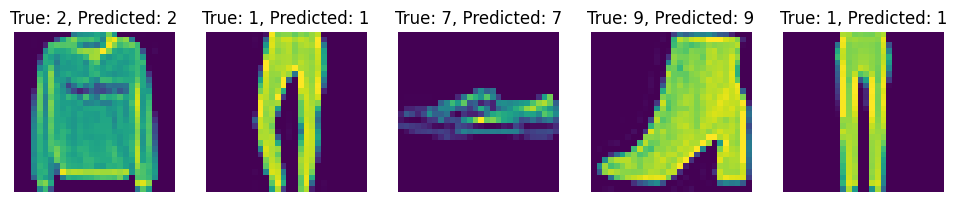

In [ ]:

# Пример использования функции
class SimpleClassifier(nn.Module):
    def __init__(self):
        super(SimpleClassifier, self).__init__()
        self.fc1 = nn.Linear(28 * 28, 128)  # Входной слой (784 входных признаков)
        self.fc2 = nn.Linear(128, 64)  # Скрытый слой
        self.fc3 = nn.Linear(64, 10)  # Выходной слой (10 классов для Fashion MNIST)

    def forward(self, x):
        x = x.view(-1, 28 * 28)  # Распрямляем входные данные
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

model = SimpleClassifier()
model.to(device)
optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=momentum)
criterion = nn.CrossEntropyLoss()

train_loader = DataLoader(train_loader1, batch_size=batch_size_train, shuffle=True)
test_loader = DataLoader(test_loader1, batch_size=batch_size_test, shuffle=False)

train_and_evaluate_model(model, optimizer, train_loader, test_loader, device, criterion, n_epochs)


### 1.2 Решить задачу 1.1, используя сверточную нейронную сеть.
* Добиться значения accuracy на тестовом множестве не менее 90%
* Визуализировать результаты работы первого сверточного слоя

Train Epoch: 1 [0/60000 (0.00%)]	Loss: 2.316916
Train Epoch: 1 [6400/60000 (10.66%)]	Loss: 0.480190
Train Epoch: 1 [12800/60000 (21.32%)]	Loss: 0.400805
Train Epoch: 1 [19200/60000 (31.98%)]	Loss: 0.332533
Train Epoch: 1 [25600/60000 (42.64%)]	Loss: 0.508492
Train Epoch: 1 [32000/60000 (53.30%)]	Loss: 0.235902
Train Epoch: 1 [38400/60000 (63.97%)]	Loss: 0.462070
Train Epoch: 1 [44800/60000 (74.63%)]	Loss: 0.323982
Train Epoch: 1 [51200/60000 (85.29%)]	Loss: 0.280763
Train Epoch: 1 [57600/60000 (95.95%)]	Loss: 0.724941
Train Epoch: 1	Average Loss: 0.422409
Train Epoch: 2 [0/60000 (0.00%)]	Loss: 0.357606
Train Epoch: 2 [6400/60000 (10.66%)]	Loss: 0.327127
Train Epoch: 2 [12800/60000 (21.32%)]	Loss: 0.226376
Train Epoch: 2 [19200/60000 (31.98%)]	Loss: 0.294906
Train Epoch: 2 [25600/60000 (42.64%)]	Loss: 0.181887
Train Epoch: 2 [32000/60000 (53.30%)]	Loss: 0.233077
Train Epoch: 2 [38400/60000 (63.97%)]	Loss: 0.298892
Train Epoch: 2 [44800/60000 (74.63%)]	Loss: 0.334051
Train Epoch: 2 [5120

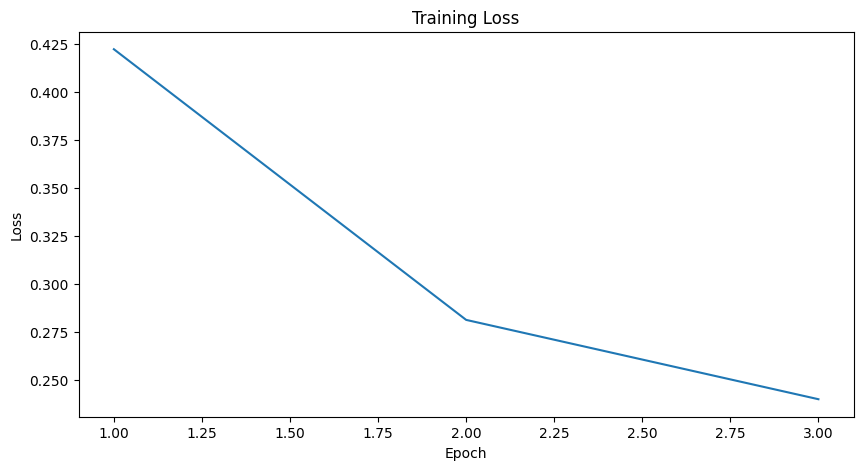

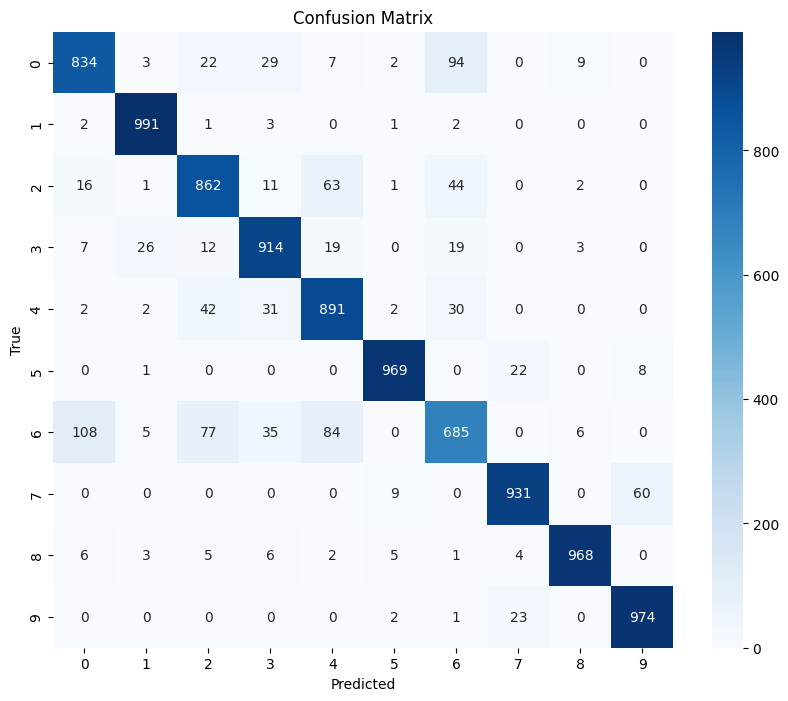

Accuracy on the test set: 90.19%


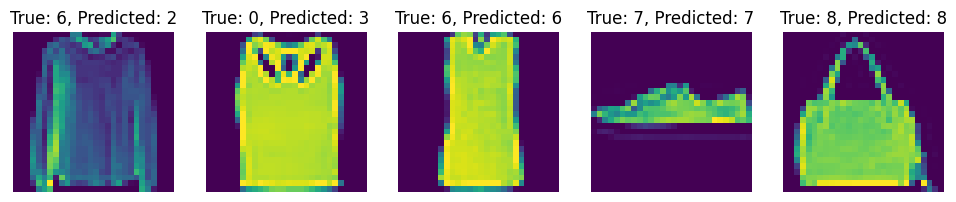

In [ ]:
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(32 * 14 * 14, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.pool(nn.functional.relu(self.conv1(x)))
        x = x.view(-1, 32 * 14 * 14)
        x = nn.functional.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Загрузка Fashion MNIST данных
transform = torchvision.transforms.Compose([torchvision.transforms.ToTensor(), torchvision.transforms.Normalize((0.5,), (0.5,))])
train_dataset = torchvision.datasets.FashionMNIST('data', train=True, download=True, transform=transform)
test_dataset = torchvision.datasets.FashionMNIST('data', train=False, download=True, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# Создание, обучение и оценка сверточной нейронной сети

convnet = ConvNet()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(convnet.parameters(), lr=0.001)

train_and_evaluate_model(convnet, optimizer, train_loader, test_loader, device, criterion, n_epochs)


##  2. Классификация изображений (датасет CIFAR 10)


### 2.1 Решить задачу классификации, не используя сверточные слои.

* Нормализовать данные (если необходимо)
* Предложить архитектуру модели для решения задачи
* Посчитать количество параметров модели.
* Обучить модель
* Вывести график функции потерь по эпохам.
* Используя тестовое множество

  * Продемонстрировать работу модели: вывести несколько изображений, указать над ними правильный класс и класс, предсказанный моделью.

  * Вывести матрицу ошибок.

  * Вывести значение accuracy на тестовом множестве.
* Сохранить модель

100%|██████████| 170498071/170498071 [00:05<00:00, 29837654.70it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified
Train Epoch: 1 [0/50000 (0.00%)]	Loss: 2.292068
Train Epoch: 1 [6400/50000 (12.79%)]	Loss: 2.023757
Train Epoch: 1 [12800/50000 (25.58%)]	Loss: 1.810225
Train Epoch: 1 [19200/50000 (38.36%)]	Loss: 1.472185
Train Epoch: 1 [25600/50000 (51.15%)]	Loss: 1.573663
Train Epoch: 1 [32000/50000 (63.94%)]	Loss: 1.560296
Train Epoch: 1 [38400/50000 (76.73%)]	Loss: 1.609041
Train Epoch: 1 [44800/50000 (89.51%)]	Loss: 1.553118
Train Epoch: 1	Average Loss: 1.696011
Train Epoch: 2 [0/50000 (0.00%)]	Loss: 1.374461
Train Epoch: 2 [6400/50000 (12.79%)]	Loss: 1.498859
Train Epoch: 2 [12800/50000 (25.58%)]	Loss: 1.530587
Train Epoch: 2 [19200/50000 (38.36%)]	Loss: 1.526896
Train Epoch: 2 [25600/50000 (51.15%)]	Loss: 1.548024
Train Epoch: 2 [32000/50000 (63.94%)]	Loss: 1.300736
Train Epoch: 2 [38400/50000 (76.73%)]	Loss: 1.553982
Train Epoch: 2 [44800/50000 (89.51%)]	Loss: 1.286106
Train Epoch: 2	Average Loss: 1.441048

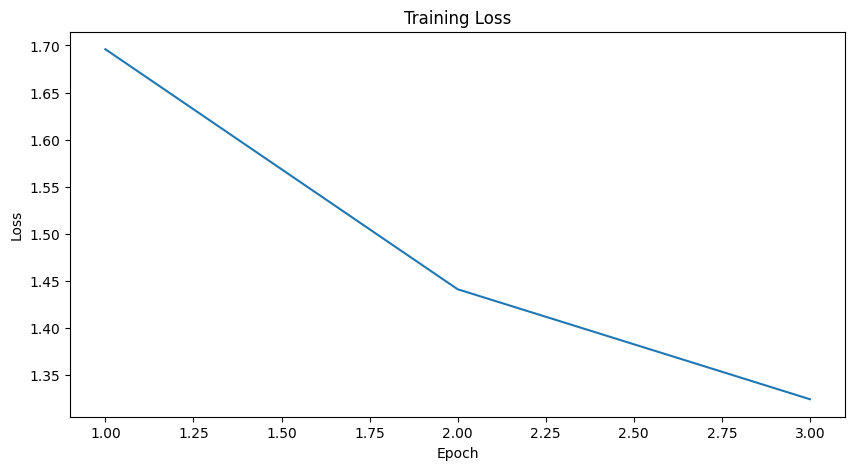

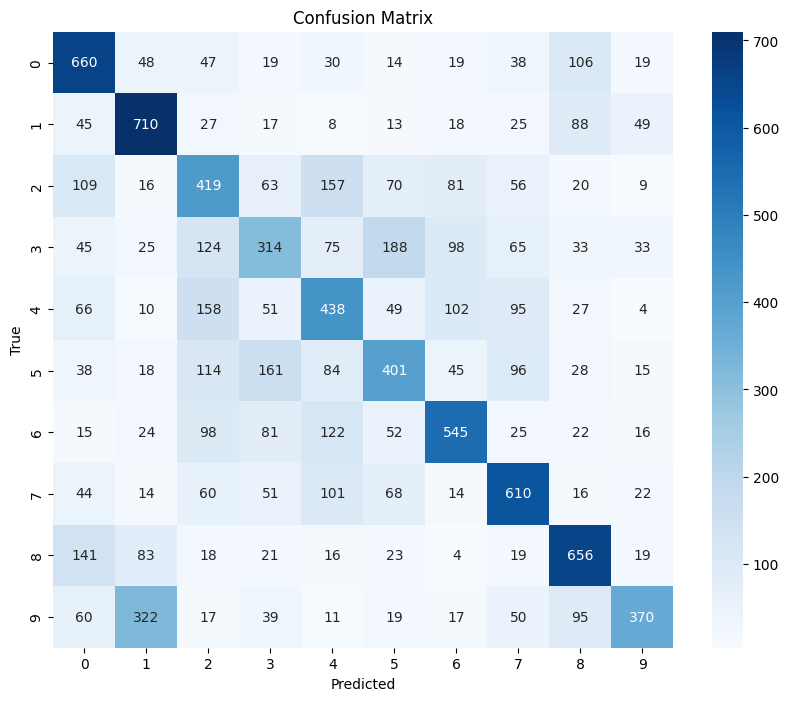

Accuracy on the test set: 51.23%


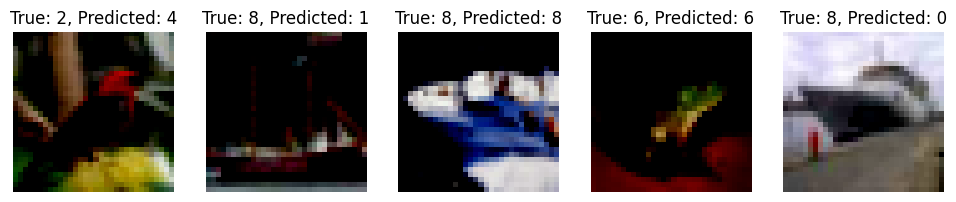

In [ ]:
transform = torchvision.transforms.Compose([torchvision.transforms.ToTensor(), torchvision.transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])


train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# Создание модели и оптимизатора
class Classifier(nn.Module):
    def __init__(self):
        super(Classifier, self).__init__()
        self.fc1 = nn.Linear(32 * 32 * 3, 512)  # Входной слой
        self.fc2 = nn.Linear(512, 128)  # Скрытый слой
        self.fc3 = nn.Linear(128, 10)  # Выходной слой

    def forward(self, x):
        x = x.view(-1, 32 * 32 * 3)
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

model = Classifier()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)


train_and_evaluate_model(model, optimizer, train_loader, test_loader,device, criterion, n_epochs)


### 2.2 Решить задачу 2.1, используя сверточную нейронную сеть.
* Добиться значения accuracy на тестовом множестве не менее 70%.
* Визуализировать результаты работы первого сверточного слоя

Files already downloaded and verified
Files already downloaded and verified
Train Epoch: 1 [0/50000 (0.00%)]	Loss: 2.303042
Train Epoch: 1 [6400/50000 (12.79%)]	Loss: 1.898261
Train Epoch: 1 [12800/50000 (25.58%)]	Loss: 1.629824
Train Epoch: 1 [19200/50000 (38.36%)]	Loss: 1.750785
Train Epoch: 1 [25600/50000 (51.15%)]	Loss: 1.410580
Train Epoch: 1 [32000/50000 (63.94%)]	Loss: 1.287881
Train Epoch: 1 [38400/50000 (76.73%)]	Loss: 1.323677
Train Epoch: 1 [44800/50000 (89.51%)]	Loss: 1.254242
Train Epoch: 1	Average Loss: 1.526492
Train Epoch: 2 [0/50000 (0.00%)]	Loss: 0.977280
Train Epoch: 2 [6400/50000 (12.79%)]	Loss: 1.107452
Train Epoch: 2 [12800/50000 (25.58%)]	Loss: 1.144775
Train Epoch: 2 [19200/50000 (38.36%)]	Loss: 1.160940
Train Epoch: 2 [25600/50000 (51.15%)]	Loss: 1.100051
Train Epoch: 2 [32000/50000 (63.94%)]	Loss: 0.863060
Train Epoch: 2 [38400/50000 (76.73%)]	Loss: 1.055558
Train Epoch: 2 [44800/50000 (89.51%)]	Loss: 1.021649
Train Epoch: 2	Average Loss: 1.112771
Train Epoch:

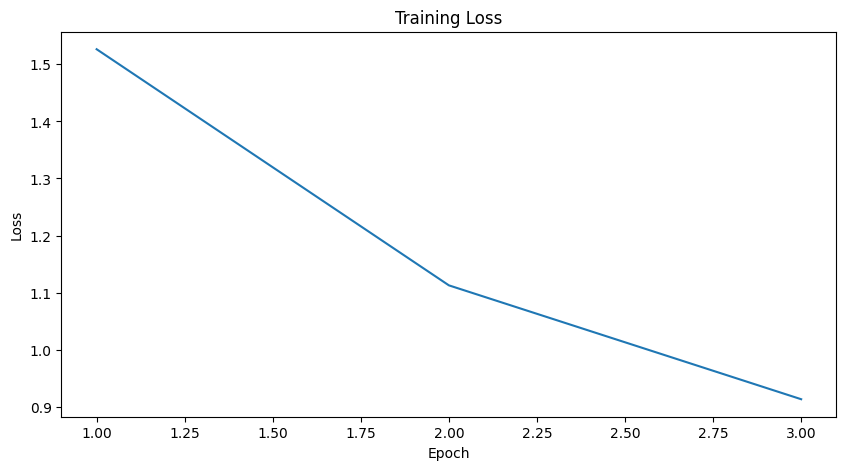

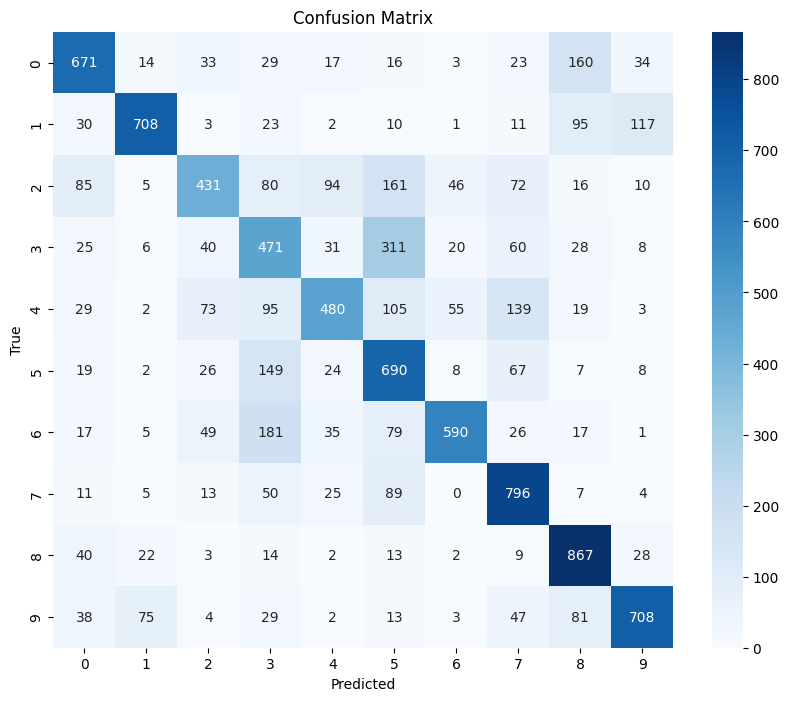

Accuracy on the test set: 64.12%


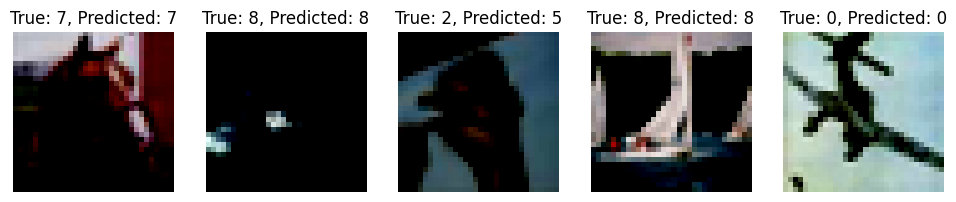

In [ ]:
transform = torchvision.transforms.Compose([torchvision.transforms.ToTensor(), torchvision.transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

# Load CIFAR-10 dataset
train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# Create a CNN model
class CNNClassifier(nn.Module):
    def __init__(self):
        super(CNNClassifier, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(64 * 16 * 16, 512)
        self.fc2 = nn.Linear(512, 128)
        self.fc3 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = x.view(-1, 64 * 16 * 16)
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# Create the model, loss function, and optimizer
model = CNNClassifier()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

# Train and evaluate the model
train_and_evaluate_model(model, optimizer, train_loader, test_loader, device, criterion, n_epochs)

## 3. Загрузка изображений из внешних источников

### 3.1 Решить задачу классификации обезьян (датасет [monkey.zip](https://disk.yandex.ru/d/OxYgY4S7aR6ulQ)).
* Загрузить архив с данными на диск
* Создать датасет на основе файлов при помощи `torchvision.datasets.ImageFolder`
* Преобразовать изображения к тензорами одного размера (например, 400х400). Потестировать другие преобразования из `torchvision.transforms`
* Предложить архитектуру модели для решения задачи. Обучить модель.
* Используя тестовое множество

  * Продемонстрировать работу модели: вывести несколько изображений, указать над ними правильный класс и класс, предсказанный моделью.

  * Вывести матрицу ошибок.

  * Вывести значение accuracy на тестовом множестве.
  * Добиться значения accuracy на тестовом множестве не менее 60%

In [ ]:
zf = zipfile.ZipFile('drive/MyDrive/datasets/monkeys.zip')
for file in tqdm(zf.infolist()):
    zf.extract(file)

100%|██████████| 1371/1371 [00:05<00:00, 264.88it/s]


In [ ]:
train_dir = '/content/training/training'  # Update with the correct path
val_dir = '/content/validation/validation'  # Update with the correct path

transform = torchvision.transforms.Compose([
    torchvision.transforms.Resize((200, 200)),  # Resize images to 400x400
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

batch_size = 64

train_dataset = torchvision.datasets.ImageFolder(root=train_dir, transform=transform)
val_dataset = torchvision.datasets.ImageFolder(root=val_dir, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)

class CNNClassifier(nn.Module):
    def __init__(self):
        super(CNNClassifier, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(64 * 100 * 100, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = x.view(-1, 64 * 100 * 100)
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x


In [ ]:
torch.cuda.empty_cache()
model = CNNClassifier()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=momentum)

train_and_evaluate_model(model, optimizer, train_loader, val_loader, device, criterion, n_epochs)

Train Epoch: 1 [0/1097 (0.00%)]	Loss: 2.303385


OutOfMemoryError: ignored

### 3.2 Решить задачу классификации собак и кошек (датасет [cats_dogs.zip](https://disk.yandex.ru/d/wQtt5O1JF9ctnA)).
* Загрузить архив с данными на диск
* Создать датасет на основе файлов при помощи `torchvision.datasets.ImageFolder`
* Преобразовать изображения к тензорами одного размера (например, 400х400). Потестировать другие преобразования из `torchvision.transforms`
* Предложить архитектуру модели для решения задачи. Обучить модель.
* Используя тестовое множество

  * Продемонстрировать работу модели: вывести несколько изображений, указать над ними правильный класс и класс, предсказанный моделью.

  * Вывести матрицу ошибок.

  * Вывести значение accuracy на тестовом множестве.
  * Добиться значения accuracy на тестовом множестве не менее 80%

In [8]:
zf = zipfile.ZipFile('drive/MyDrive/datasets/cats_dogs.zip')
for file in tqdm(zf.infolist()):
    zf.extract(file)

100%|██████████| 25004/25004 [00:13<00:00, 1919.61it/s]


In [9]:
import os
import shutil
from sklearn.model_selection import train_test_split

# Папка с исходными данными
data_dir = '/content/cats_dogs/train'

# Папки для обучающего и валидационного наборов данных
train_dir = '/content/cats_dogs/train_set'
val_dir = '/content/cats_dogs/val_set'

# Создайте папки, если их нет
os.makedirs(train_dir, exist_ok=True)
os.makedirs(val_dir, exist_ok=True)

import shutil
from sklearn.model_selection import train_test_split

# Список классов (папок) в папке с данными
classes = os.listdir(data_dir)

# Разделите каждый класс на обучающий и валидационный наборы данных
for class_name in classes:
    class_dir = os.path.join(data_dir, class_name)
    train_class_dir = os.path.join(train_dir, class_name)
    val_class_dir = os.path.join(val_dir, class_name)

    # Создайте папки для классов, если их нет
    os.makedirs(train_class_dir, exist_ok=True)
    os.makedirs(val_class_dir, exist_ok=True)

    # Получите список файлов для данного класса
    class_files = os.listdir(class_dir)

    # Разделите файлы на обучающий и валидационный наборы данных
    train_files, val_files = train_test_split(class_files, test_size=0.2, random_state=42)

    # Скопируйте файлы в соответствующие папки
    for file in train_files:
        src = os.path.join(class_dir, file)
        dest = os.path.join(train_class_dir, file)
        shutil.copy(src, dest)

    for file in val_files:
        src = os.path.join(class_dir, file)
        dest = os.path.join(val_class_dir, file)
        shutil.copy(src, dest)
class CNNClassifier(nn.Module):
    def __init__(self):
        super(CNNClassifier, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(64 * 100 * 100, 128)
        self.fc2 = nn.Linear(128, 3)

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = x.view(-1, 64 * 100 * 100)
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [10]:
train_dir = '/content/cats_dogs/train_set'  # Update with the correct path
val_dir = '/content/cats_dogs/val_set'  # Update with the correct path

transform = torchvision.transforms.Compose([
    torchvision.transforms.Resize((200, 200)),  # Resize images to 400x400
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

batch_size = 64

train_dataset = torchvision.datasets.ImageFolder(root=train_dir, transform=transform)
val_dataset = torchvision.datasets.ImageFolder(root=val_dir, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)


In [ ]:
torch.cuda.empty_cache()
model = CNNClassifier()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=momentum)

train_and_evaluate_model(model, optimizer, train_loader, val_loader, device, criterion, n_epochs)

Train Epoch: 1 [0/20000 (0.00%)]	Loss: 2.366962


OutOfMemoryError: ignored

# 4. Transfer Learning

### 4.1 Решить задачу 3.1, воспользовавшись предобученной моделью VGG16
* Загрузить данные для обучения
* Преобразования: размер 224x224, нормализация с параметрами `mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)`
* Заменить последний полносвязный слой модели в соответствии с задачей
* Дообучить модель (не замораживать веса). Вычислить значение accuracy на тестовом множестве
* Дообучить модель (заморозить все веса, кроме последнего блока слоев (`classifier`)).
* Вычислить значение accuracy на тестовом множестве.


In [11]:
zf = zipfile.ZipFile('drive/MyDrive/datasets/monkeys.zip')
for file in tqdm(zf.infolist()):
    zf.extract(file)

100%|██████████| 1371/1371 [00:03<00:00, 345.61it/s]


In [12]:
train_dir = '/content/training/training'  # Update with the correct path
val_dir = '/content/validation/validation'  # Update with the correct path

transform = torchvision.transforms.Compose([
    torchvision.transforms.Resize((224, 224)),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
])

batch_size = 64

train_dataset = torchvision.datasets.ImageFolder(root=train_dir, transform=transform)
val_dataset = torchvision.datasets.ImageFolder(root=val_dir, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)


In [13]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
from PIL import Image
from tempfile import TemporaryDirectory

cudnn.benchmark = True
plt.ion()

In [16]:
import os
import torch
from torchvision import transforms, datasets
from torch.utils.data import DataLoader

data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
    ]),
    'val': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
    ]),
}

data_dir = '/content/'  # Укажите путь к основой директории данных

# Добавляем пути к обучающим и тестовым данным
data_paths = {
    'train': 'training/training',
    'val': 'validation/validation'
}

image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, data_paths[x]), data_transforms[x])
                  for x in ['train', 'val']}

dataloaders = {x: DataLoader(image_datasets[x], batch_size=64, shuffle=True, num_workers=4)
              for x in ['train', 'val']}

dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


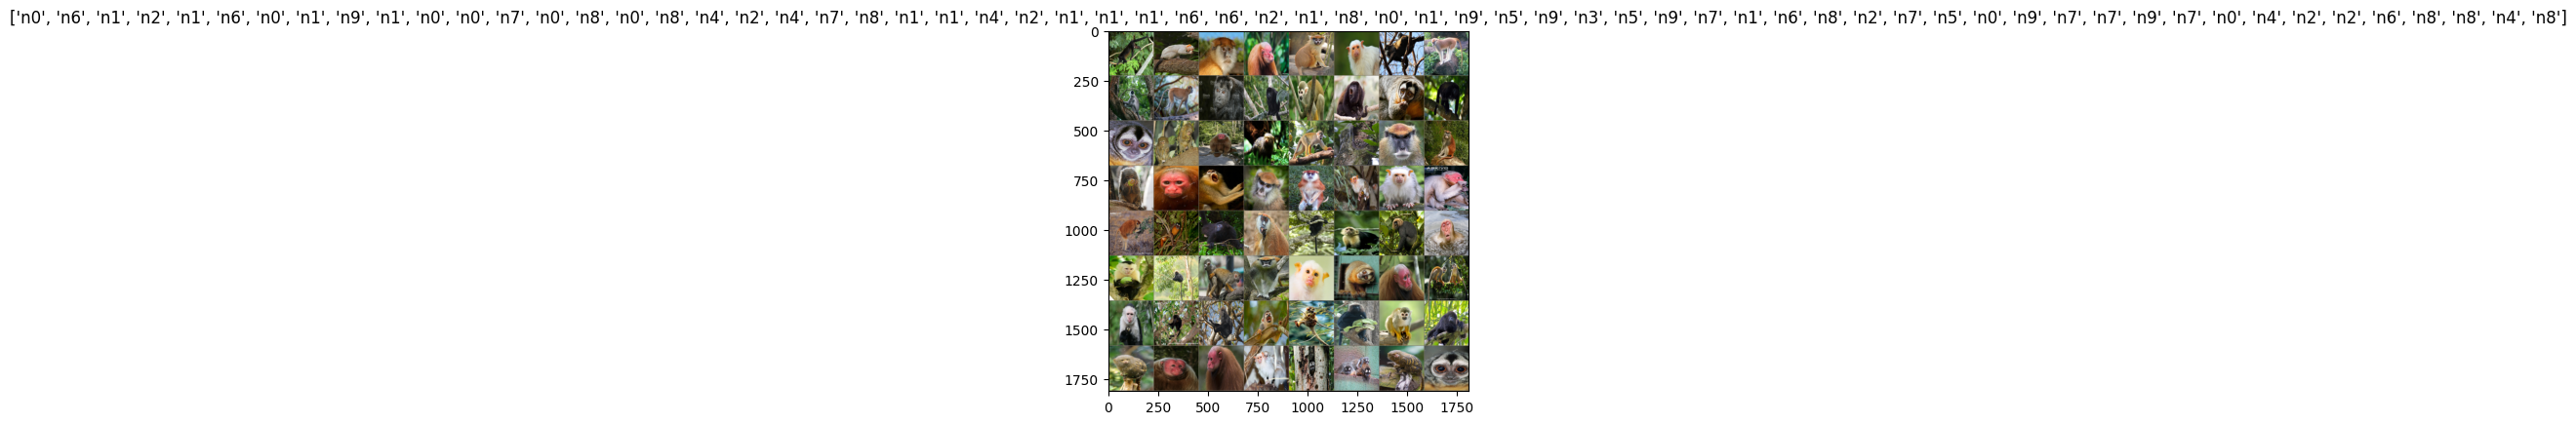

In [17]:
def imshow(inp, title=None):
    """Display image for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [18]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    # Create a temporary directory to save training checkpoints
    with TemporaryDirectory() as tempdir:
        best_model_params_path = os.path.join(tempdir, 'best_model_params.pt')

        torch.save(model.state_dict(), best_model_params_path)
        best_acc = 0.0

        for epoch in range(num_epochs):
            print(f'Epoch {epoch}/{num_epochs - 1}')
            print('-' * 10)

            # Each epoch has a training and validation phase
            for phase in ['train', 'val']:
                if phase == 'train':
                    model.train()  # Set model to training mode
                else:
                    model.eval()   # Set model to evaluate mode

                running_loss = 0.0
                running_corrects = 0

                # Iterate over data.
                for inputs, labels in dataloaders[phase]:
                    inputs = inputs.to(device)
                    labels = labels.to(device)

                    # zero the parameter gradients
                    optimizer.zero_grad()

                    # forward
                    # track history if only in train
                    with torch.set_grad_enabled(phase == 'train'):
                        outputs = model(inputs)
                        _, preds = torch.max(outputs, 1)
                        loss = criterion(outputs, labels)

                        # backward + optimize only if in training phase
                        if phase == 'train':
                            loss.backward()
                            optimizer.step()

                    # statistics
                    running_loss += loss.item() * inputs.size(0)
                    running_corrects += torch.sum(preds == labels.data)
                if phase == 'train':
                    scheduler.step()

                epoch_loss = running_loss / dataset_sizes[phase]
                epoch_acc = running_corrects.double() / dataset_sizes[phase]

                print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

                # deep copy the model
                if phase == 'val' and epoch_acc > best_acc:
                    best_acc = epoch_acc
                    torch.save(model.state_dict(), best_model_params_path)

            print()

        time_elapsed = time.time() - since
        print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
        print(f'Best val Acc: {best_acc:4f}')

        # load best model weights
        model.load_state_dict(torch.load(best_model_params_path))
    return model

In [19]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'predicted: {class_names[preds[j]]}')
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [20]:
model_ft = models.resnet18(weights='IMAGENET1K_V1')
num_ftrs = model_ft.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to ``nn.Linear(num_ftrs, len(class_names))``.
model_ft.fc = nn.Linear(num_ftrs, 10)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 132MB/s]


In [21]:
model_ft = models.vgg16(weights='IMAGENET1K_V1')

# Получение количества входных признаков (num_ftrs) в полносвязном слое
num_ftrs = model_ft.classifier[6].in_features

# Замена полносвязного слоя на новый слой с 2 выходами
model_ft.classifier[6] = nn.Linear(num_ftrs, 10)

model_ft = model_ft.to(device)

# Функция потерь
criterion = nn.CrossEntropyLoss()

# Оптимизатор SGD
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Уменьшение learning rate (скорости обучения) на 0.1 каждые 7 эпох
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:05<00:00, 109MB/s] 


In [22]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=25)

Epoch 0/24
----------
train Loss: 1.3722 Acc: 0.5697
val Loss: 0.0957 Acc: 0.9816

Epoch 1/24
----------
train Loss: 0.0915 Acc: 0.9727
val Loss: 0.0623 Acc: 0.9816

Epoch 2/24
----------
train Loss: 0.0589 Acc: 0.9781
val Loss: 0.0626 Acc: 0.9706

Epoch 3/24
----------
train Loss: 0.0508 Acc: 0.9836
val Loss: 0.0504 Acc: 0.9779

Epoch 4/24
----------
train Loss: 0.0166 Acc: 0.9954
val Loss: 0.0237 Acc: 0.9963

Epoch 5/24
----------
train Loss: 0.0076 Acc: 0.9991
val Loss: 0.0152 Acc: 0.9963

Epoch 6/24
----------
train Loss: 0.0035 Acc: 1.0000
val Loss: 0.0152 Acc: 0.9963

Epoch 7/24
----------
train Loss: 0.0040 Acc: 0.9991
val Loss: 0.0154 Acc: 0.9963

Epoch 8/24
----------
train Loss: 0.0027 Acc: 1.0000
val Loss: 0.0147 Acc: 0.9963

Epoch 9/24
----------
train Loss: 0.0029 Acc: 0.9991
val Loss: 0.0141 Acc: 0.9963

Epoch 10/24
----------
train Loss: 0.0023 Acc: 1.0000
val Loss: 0.0135 Acc: 0.9963

Epoch 11/24
----------
train Loss: 0.0017 Acc: 1.0000
val Loss: 0.0133 Acc: 0.9963

Ep

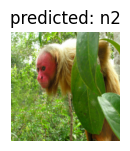

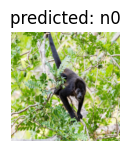

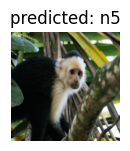

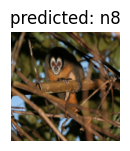

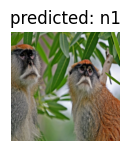

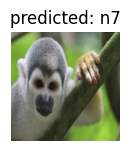

In [23]:
visualize_model(model_ft)

### 4.2 Решить задачу 3.2, воспользовавшись подходящей предобученной моделью
* Не использовать VGG16 (вместо нее можно взять resnet18 или другую)
* Загрузить данные для обучения
* Преобразования: размер 224x224, нормализация с параметрами `mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)`
* Заменить последний полносвязный слой модели в соответствии с задачей
* Дообучить модель.
* Вычислить значение accuracy на тестовом множестве (добиться значения не меньше 97-98%)